In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
np.random.seed(666)

Using TensorFlow backend.


In [2]:
#Load data
train = pd.read_json("train.json")
test = pd.read_json("test.json")

# replace NAs with 0 in inc_angle column.
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

# Explatory data analysis
---

### Plotting Statistics

Now, I will look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

In [3]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

In [4]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

**Histograms for band_1**

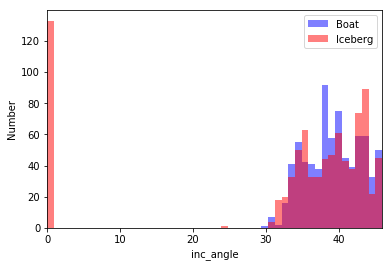

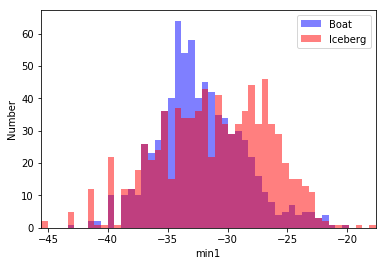

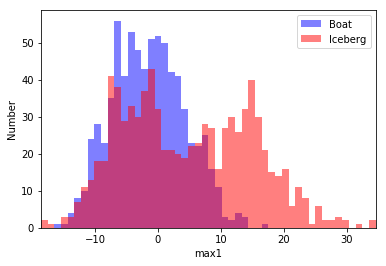

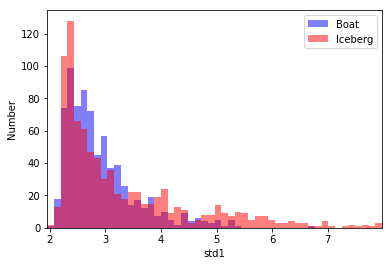

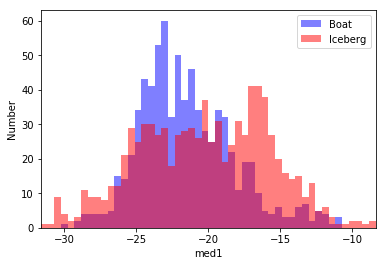

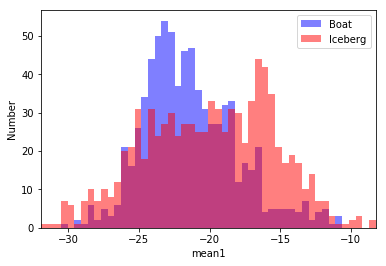

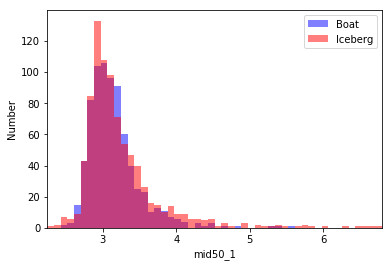

In [5]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

**Histograms for band_2**

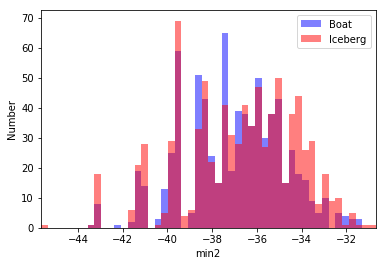

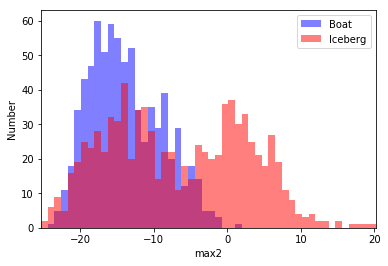

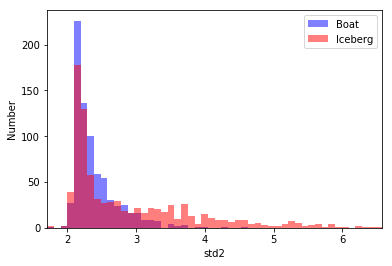

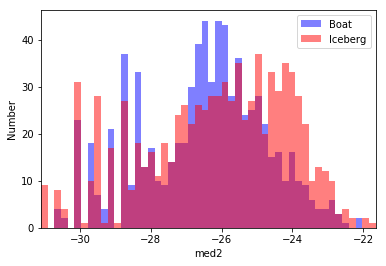

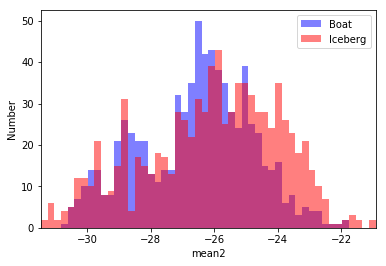

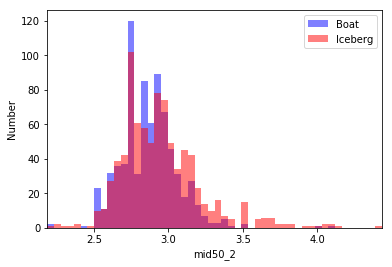

In [6]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

We get similar results for band2.

### Correlations Between Features

Now that we've established that these variables may have some use, we should look at the correlations between them. For this, I'll just plot the correlation matrix. It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn), but i won't do that here.

In [7]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

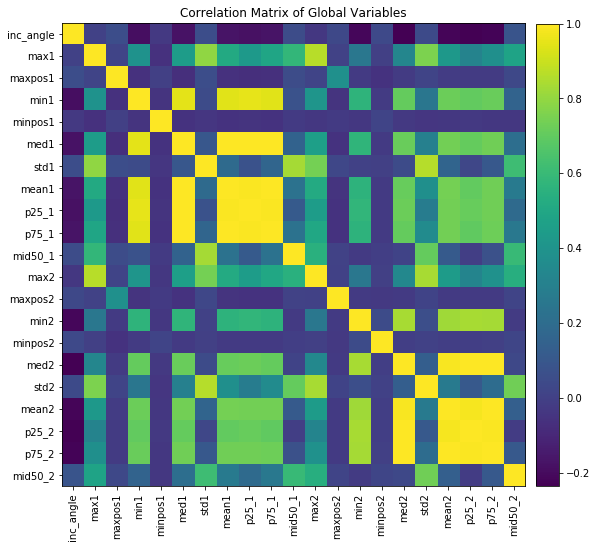

In [8]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='viridis')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

We see that there are large correlations between some of the variables. In particular, the mean, median, 25% signal, and 75% signal are all closely related, with nearly 75% correlation. The min and max are also pretty highly correlated for band 1, as are the min and median for both bands, suggesting that the signals have maybe been scaled in some way to force this correlation. There are also some correlations between the two bands. Finally, we see an anticorrelation of around -0.5 between the mean of band 2 and the angle, with a weaker correlation for band 1.

### Plotting iceberg and ship Images of both bands

It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands.

In [9]:
icebergs = train[train.is_iceberg==1].sample(n=3,random_state=123)
ships = train[train.is_iceberg==0].sample(n=3,random_state=456)

**images of icebergs in band_1 :- **

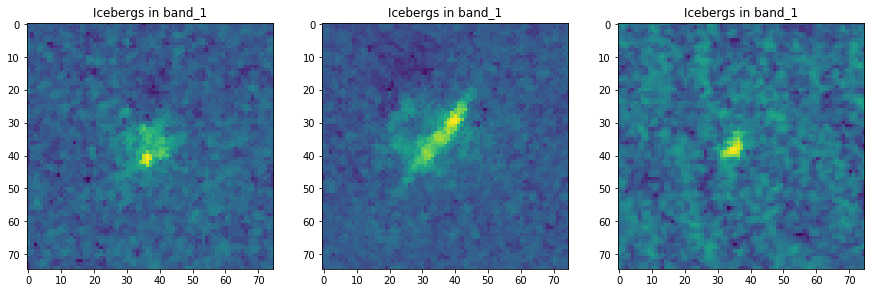

In [10]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    plt.title('Icebergs in band_1')
    ax.imshow(arr,cmap='viridis')
plt.show()

** images of ships in band_1**

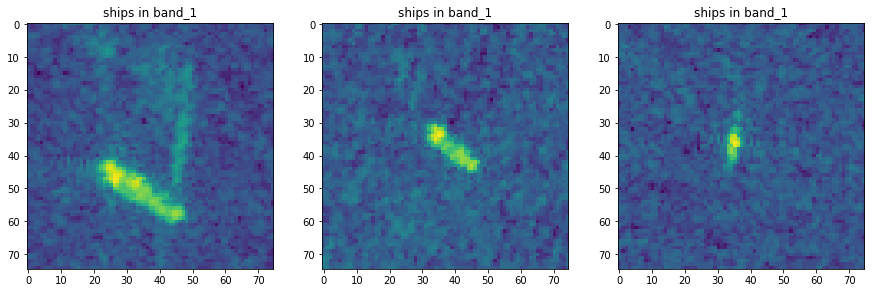

In [11]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    plt.title('ships in band_1')
    ax.imshow(arr,cmap='viridis')
    
plt.show()

**The next set show the same set of icebergs in band 2.**

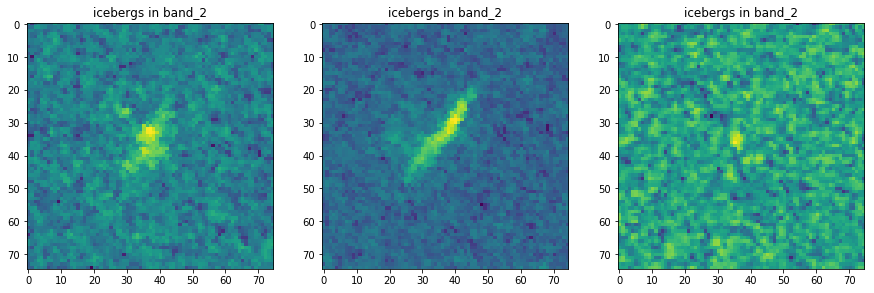

In [12]:
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    plt.title('icebergs in band_2')
    ax.imshow(arr,cmap='viridis')
    
plt.show()

**Same set of ships in band 2.**

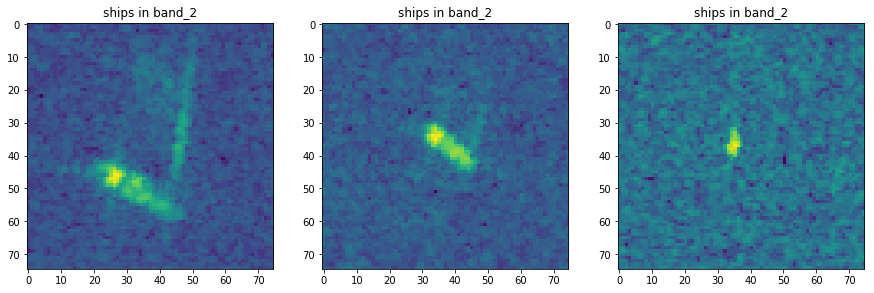

In [13]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    plt.title('ships in band_2')
    ax.imshow(arr,cmap='viridis')
    
plt.show()

So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye

# Benchmark model
 ----

In [14]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
y_train = np.array(train["is_iceberg"])
print("Xtrain:", X_train.shape)
print("Ytrain:", y_train.shape)
# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
print("Xtest:", X_test.shape)

Xtrain: (1604, 75, 75, 2)
Ytrain: (1604,)
Xtest: (8424, 75, 75, 2)


In [15]:
from keras.models import Sequential
from keras.layers import Convolution2D, GlobalAveragePooling2D, Dense, Dropout

In [16]:
model = Sequential()
model.add(Convolution2D(32, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(Convolution2D(64, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,169
Trainable params: 19,169
Non-trainable params: 0
_________________________________________________________________


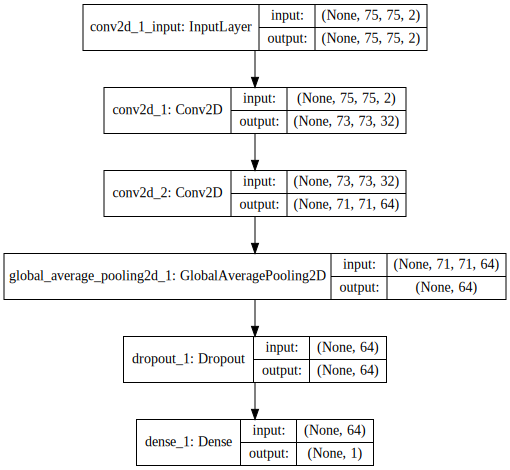

In [17]:
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [18]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True)

In [19]:
xz = model.fit(X_train, y_train, validation_split=0.25)

Train on 1203 samples, validate on 401 samples
Epoch 1/1
1203/1203 [==============================] - 13s 10ms/step - loss: 0.9581 - acc: 0.5777 - val_loss: 0.6342 - val_acc: 0.6060


In [20]:
xz.history

{'acc': [0.57772236106203478],
 'loss': [0.9581378629974594],
 'val_acc': [0.60598503829832384],
 'val_loss': [0.63422485286755459]}

The benchmark model gives validation accuracy of 60.60%.

 --------

# Improved model.

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D, Dense
improved_cnn = Sequential()
improved_cnn.add(BatchNormalization(input_shape = (75, 75, 2)))
for i in range(4):
    improved_cnn.add(Conv2D(8*2**i, kernel_size = (3,3)))
    improved_cnn.add(MaxPooling2D((2,2)))
improved_cnn.add(GlobalMaxPooling2D())
improved_cnn.add(Dropout(0.2))
improved_cnn.add(Dense(64))
improved_cnn.add(Dropout(0.2))
improved_cnn.add(Dense(32))
improved_cnn.add(Dense(1, activation = 'sigmoid'))
improved_cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
improved_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 75, 75, 2)         8         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 73, 73, 8)         152       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
__________

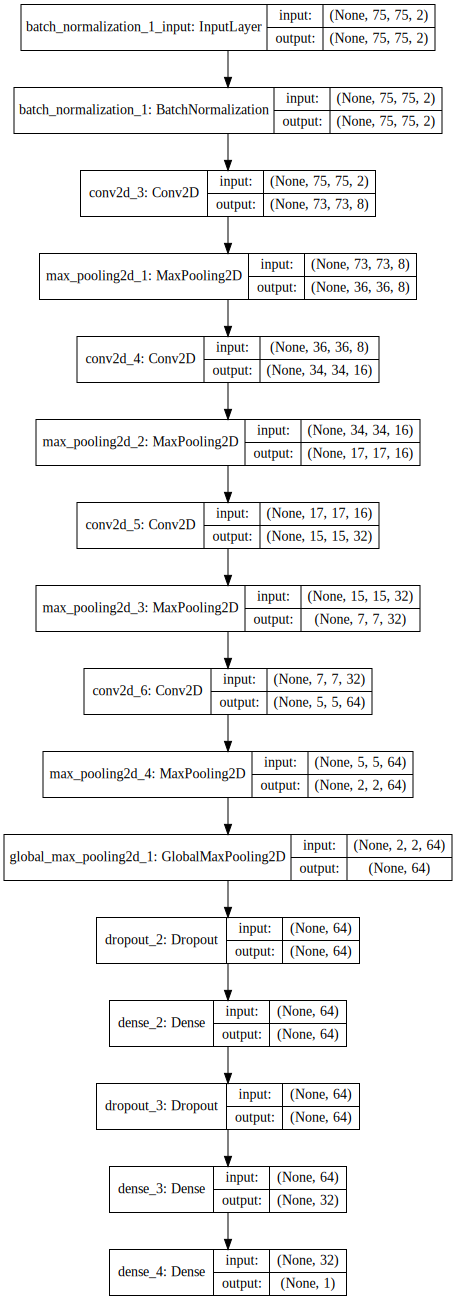

In [22]:
SVG(model_to_dot(improved_cnn, show_shapes = True).create(prog='dot', format='svg'))

In [23]:
history1 = improved_cnn.fit(X_train, y_train, validation_split=0.2, epochs = 10)

Train on 1283 samples, validate on 321 samples
Epoch 1/10
1283/1283 [==============================] - 4s 3ms/step - loss: 0.6383 - acc: 0.6181 - val_loss: 0.7371 - val_acc: 0.5888
Epoch 2/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.4892 - acc: 0.7451 - val_loss: 0.8427 - val_acc: 0.6947
Epoch 3/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.4382 - acc: 0.7966 - val_loss: 0.6426 - val_acc: 0.6604
Epoch 4/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.3715 - acc: 0.8355 - val_loss: 0.4234 - val_acc: 0.7695
Epoch 5/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.3153 - acc: 0.8675 - val_loss: 0.6621 - val_acc: 0.6604
Epoch 6/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.2816 - acc: 0.8823 - val_loss: 0.4013 - val_acc: 0.8037
Epoch 7/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.2189 - acc: 0.9096 - val_loss: 0.4379 - val_acc: 0.7695
Epoch 8/10
1283

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


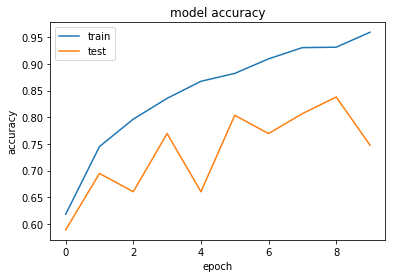

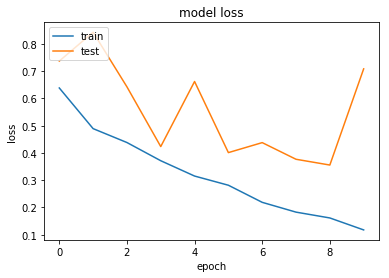

In [24]:
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The improved model has validation accuracy of 83.80%. This is becuase of more convolution layers.

In [25]:
# Make predictions
prediction = improved_cnn.predict(X_test, verbose=1)

8424/8424 [==============================] - 4s 433us/step


In [26]:
submit_df = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.flatten()})
submit_df.to_csv("./improved_cnn.csv", index=False)

** This model gives a public leader board score of 0.36.**

# 3rd Model: Transfer learning with vgg16 and image augmentation

In [27]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [28]:
train = pd.read_json("train.json")
target_train=train['is_iceberg']
test = pd.read_json("test.json")


In [29]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [30]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [31]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [32]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


In [33]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [34]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [35]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


In [36]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(input=[base_model.input, input_2], output=predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [38]:


#def myAngleCV(X_train, X_angle, X_test):
K=3
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


Epoch 1/100
24/24 [==============================] - 76s 3s/step - loss: 0.7161 - acc: 0.6493 - val_loss: 0.3315 - val_acc: 0.8206
Epoch 2/100
24/24 [==============================] - 55s 2s/step - loss: 0.4043 - acc: 0.8127 - val_loss: 0.2502 - val_acc: 0.8785
Epoch 3/100
24/24 [==============================] - 54s 2s/step - loss: 0.3514 - acc: 0.8425 - val_loss: 0.2262 - val_acc: 0.8991
Epoch 4/100
24/24 [==============================] - 55s 2s/step - loss: 0.2835 - acc: 0.8806 - val_loss: 0.2042 - val_acc: 0.9028
Epoch 5/100
24/24 [==============================] - 53s 2s/step - loss: 0.2746 - acc: 0.8785 - val_loss: 0.2317 - val_acc: 0.8916
Epoch 6/100
24/24 [==============================] - 54s 2s/step - loss: 0.2588 - acc: 0.8851 - val_loss: 0.2089 - val_acc: 0.9140
Epoch 7/100
24/24 [==============================] - 55s 2s/step - loss: 0.2604 - acc: 0.8853 - val_loss: 0.2030 - val_acc: 0.9159
Epoch 8/100
24/24 [==============================] - 53s 2s/step - loss: 0.2333 - a

24/24 [==============================] - 53s 2s/step - loss: 0.2231 - acc: 0.9011 - val_loss: 0.2740 - val_acc: 0.8876
Epoch 9/100
24/24 [==============================] - 54s 2s/step - loss: 0.2032 - acc: 0.9073 - val_loss: 0.2740 - val_acc: 0.8933
Epoch 10/100
24/24 [==============================] - 53s 2s/step - loss: 0.1829 - acc: 0.9233 - val_loss: 0.2838 - val_acc: 0.8764
Epoch 11/100
24/24 [==============================] - 54s 2s/step - loss: 0.1931 - acc: 0.9271 - val_loss: 0.2691 - val_acc: 0.8933
Epoch 12/100
24/24 [==============================] - 54s 2s/step - loss: 0.1825 - acc: 0.9239 - val_loss: 0.2808 - val_acc: 0.8970
Epoch 13/100
24/24 [==============================] - 53s 2s/step - loss: 0.1670 - acc: 0.9449 - val_loss: 0.2732 - val_acc: 0.8989
Epoch 14/100
24/24 [==============================] - 54s 2s/step - loss: 0.1677 - acc: 0.9405 - val_loss: 0.2794 - val_acc: 0.8933
Epoch 15/100
24/24 [==============================] - 53s 2s/step - loss: 0.1671 - acc: 0.

In [39]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [40]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)

This submission has a public leader board score of 0.1784

### Final model accuracy and loss plot

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


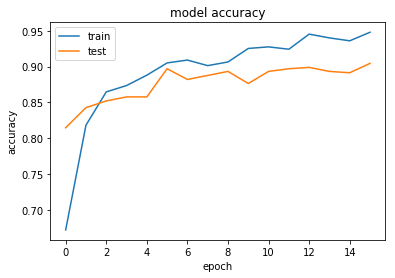

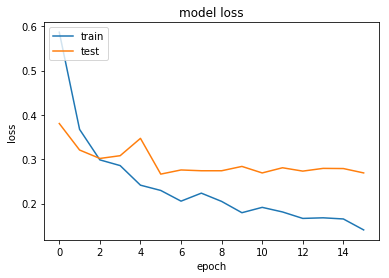

In [41]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lets see some validation set images and compare actual and predicted values.

In [42]:
import matplotlib.image as mpimg

In [43]:
min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

In [44]:
X_holdout2 = my_sum(X_holdout)

In [45]:
X_holdout2.shape

(534, 75, 75, 3)

Text(0.5,1,'Actual label : 0, iceberg_probability : [ 0.12805137]')

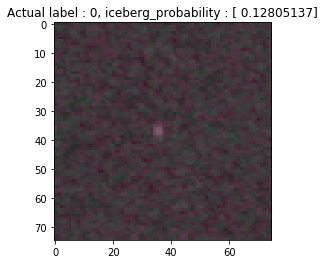

In [46]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[9])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

Correct classification

Text(0.5,1,'Actual label : 0, iceberg_probability : [ 0.00921048]')

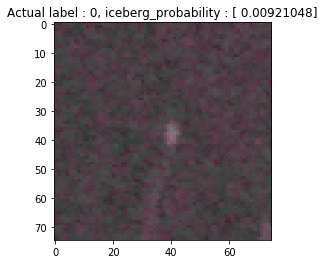

In [47]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

Correct Classification

Text(0.5,1,'Actual label : 1, iceberg_probability : [ 0.59834248]')

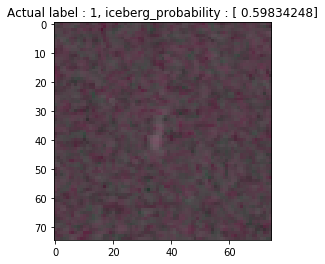

In [48]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[19])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

Correct classififcation.

Text(0.5,1,'Actual label : 1, iceberg_probability : [ 0.99728632]')

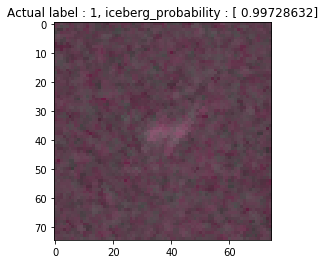

In [49]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[23])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

Correct Classififcation